In [3]:
# Load Libraries
import os
import numpy as np
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import ToTensor, Normalize
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import torchvision.transforms as transforms
from torchvision.transforms import RandomHorizontalFlip, RandomRotation, ColorJitter, RandomAffine, RandomResizedCrop
import random

# Paths to the extracted directories
img_train_path = '/content/drive/MyDrive/img/img/train'
img_test_path = '/content/drive/MyDrive/img/img/test'
img_val_path = '/content/drive/MyDrive/img/img/val'

mask_train_path = '/content/drive/MyDrive/mask/mask/train'
mask_test_path = '/content/drive/MyDrive/mask/mask/test'
mask_val_path = '/content/drive/MyDrive/mask/mask/val'

bbox_label_path_train = '/content/drive/MyDrive/bbox_label_train.csv'
bbox_label_path_val = '/content/drive/MyDrive/bbox_label_val.csv'
bbox_label_path_test = '/content/drive/MyDrive/bbox_label_test.csv'


# Function to get sorted list of files from a directory
def get_file_list(directory):
    return sorted([f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))])

# Getting the file lists for each dataset split
img_train_list = get_file_list(img_train_path)
mask_train_list = get_file_list(mask_train_path)

img_test_list = get_file_list(img_test_path)
mask_test_list = get_file_list(mask_test_path)

img_val_list = get_file_list(img_val_path)
mask_val_list = get_file_list(mask_val_path)

# Debugging: Print lengths of the file lists
print(f"Number of training images: {len(img_train_list)}")
print(f"Number of training masks: {len(mask_train_list)}")
print(f"Number of testing images: {len(img_test_list)}")
print(f"Number of testing masks: {len(mask_test_list)}")
print(f"Number of validation images: {len(img_val_list)}")
print(f"Number of validation masks: {len(mask_val_list)}")

# Load and debug the bounding box labels
bbox_labels_train = pd.read_csv(bbox_label_path_train, header=None, names=['filename', 'xmin', 'ymin', 'xmax', 'ymax', 'defect_type'])
bbox_labels_val = pd.read_csv(bbox_label_path_val, header=None, names=['filename', 'xmin', 'ymin', 'xmax', 'ymax', 'defect_type'])
bbox_labels_test = pd.read_csv(bbox_label_path_test, header=None, names=['filename', 'xmin', 'ymin', 'xmax', 'ymax', 'defect_type'])

print("Train CSV columns:", bbox_labels_train.columns)
print("Val CSV columns:", bbox_labels_val.columns)
print("Test CSV columns:", bbox_labels_test.columns)

# Custom Dataset class for handling images, masks, and bounding box labels
class CustomDataset(Dataset):
    def __init__(self, img_list, mask_list, img_dir, mask_dir, bbox_labels, transform=None, num_samples=None):
        self.img_list = img_list
        self.mask_list = mask_list
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.bbox_labels = bbox_labels
        self.transform = transform

        # Randomly sample indices if num_samples is provided, else use all indices
        if num_samples is not None:
            self.indices = random.sample(range(len(img_list)), num_samples)
        else:
            self.indices = range(len(img_list))

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        idx = self.indices[idx]
        img_path = os.path.join(self.img_dir, self.img_list[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_list[idx])

        # Load images and masks
        image = Image.open(img_path).convert("L")  # Convert to grayscale
        mask = Image.open(mask_path)

        # Apply transformations if specified
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        # Convert PIL Image to tensor if not already
        if not isinstance(image, torch.Tensor):
            image = transforms.ToTensor()(image)
        if not isinstance(mask, torch.Tensor):
            mask = transforms.ToTensor()(mask)

        # Filter the bounding boxes for the current image
        bbox = self.bbox_labels[self.bbox_labels['filename'] == self.img_list[idx]]
        bbox = bbox[['xmin', 'ymin', 'xmax', 'ymax']].values.flatten().astype(np.float32)

        return image, mask, torch.tensor(bbox)

# Define additional transformations for data augmentation
augmentation_transform = transforms.Compose([
    RandomHorizontalFlip(p=0.5),  # 50% chance of horizontal flip
    RandomRotation(degrees=(-10, 10)),  # Random rotation between -10 to 10 degrees
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly change brightness, contrast, saturation, hue
    RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),  # Random affine transformation
    RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0), ratio=(0.75, 1.333))  # Random resized crop
])

# Combine augmentation with original transform
transform = transforms.Compose([
    augmentation_transform,
    transforms.ToTensor()
])

# Create datasets with random sampling
num_train_samples = 100
num_test_samples = 20
num_val_samples = 20

train_dataset = CustomDataset(img_train_list, mask_train_list, img_train_path, mask_train_path, bbox_labels_train, transform=transform, num_samples=num_train_samples)
test_dataset = CustomDataset(img_test_list, mask_test_list, img_test_path, mask_test_path, bbox_labels_test, num_samples=num_test_samples)
val_dataset = CustomDataset(img_val_list, mask_val_list, img_val_path, mask_val_path, bbox_labels_val , num_samples=num_val_samples)

# Check dataset lengths for debugging
print(f"Training dataset length: {len(train_dataset)}")
print(f"Testing dataset length: {len(test_dataset)}")
print(f"Validation dataset length: {len(val_dataset)}")

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=3, shuffle=False)

# Define a simple CNN model for segmentation
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(16, 1, kernel_size=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dropout = nn.Dropout(0.15)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.relu(self.conv3(x))
        x = self.maxpool(x)
        x = self.relu(self.conv4(x))
        x = self.maxpool(x)
        x = self.relu(self.conv5(x))
        x = self.dropout(x)
        x = self.upsample(x)
        x = self.upsample(x)
        x = self.upsample(x)
        x = self.upsample(x)
        x = self.conv6(x)
        return x

# Selecting the appropriate training device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SimpleCNN().to(device)

# Define the loss function and the optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model_save_path = '/content/drive/MyDrive/model.pth'


Number of training images: 2500
Number of training masks: 2500
Number of testing images: 1000
Number of testing masks: 1000
Number of validation images: 500
Number of validation masks: 500
Train CSV columns: Index(['filename', 'xmin', 'ymin', 'xmax', 'ymax', 'defect_type'], dtype='object')
Val CSV columns: Index(['filename', 'xmin', 'ymin', 'xmax', 'ymax', 'defect_type'], dtype='object')
Test CSV columns: Index(['filename', 'xmin', 'ymin', 'xmax', 'ymax', 'defect_type'], dtype='object')
Training dataset length: 100
Testing dataset length: 20
Validation dataset length: 20


Epoch 1/5
Training Loss: 0.1291, Accuracy: 0.8923, Time: 39.40s
Validation Loss: 0.1518, Accuracy: 0.9528
Model saved at /content/drive/MyDrive/model.pth
Epoch 2/5
Training Loss: 0.1271, Accuracy: 0.9189, Time: 19.89s
Validation Loss: 0.1323, Accuracy: 0.9528
Model saved at /content/drive/MyDrive/model.pth
Epoch 3/5
Training Loss: 0.1255, Accuracy: 0.8653, Time: 20.54s
Validation Loss: 0.1395, Accuracy: 0.9528
Epoch 4/5
Training Loss: 0.1339, Accuracy: 0.8841, Time: 19.79s
Validation Loss: 0.1316, Accuracy: 0.9528
Model saved at /content/drive/MyDrive/model.pth
Epoch 5/5
Training Loss: 0.1259, Accuracy: 0.8568, Time: 19.80s
Validation Loss: 0.1321, Accuracy: 0.9528


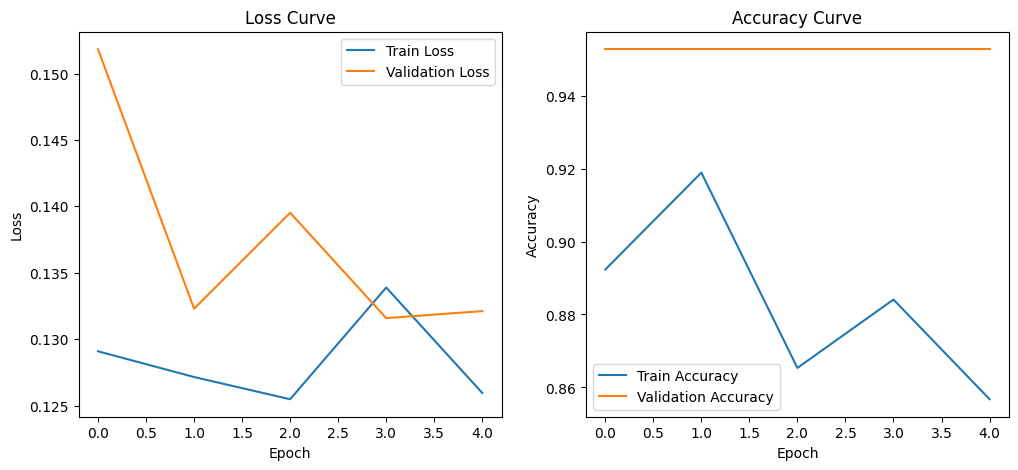

In [5]:
# Training loop
import time

# Number of epochs to train the model
num_epochs = 5

# Initialize the best validation loss to infinity
best_val_loss = float('inf')

# Dictionary to store the training and validation history
train_history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

# Function to compute the accuracy of the model's outputs
def compute_accuracy(outputs, targets):
    # Convert the outputs to binary predictions (> 0.5 is 1, else 0)
    outputs = (outputs > 0.5).float()
    # Count the number of correct predictions
    correct = (outputs == targets).float().sum()
    # Calculate the accuracy
    accuracy = correct / targets.numel()
    return accuracy.item()

# Training loop
for epoch in range(num_epochs):
    start = time.time()
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Set the model to training mode
    model.train()
    running_loss = 0.0
    train_accuracies = []
    i = 1
    for images, masks, bbox_labels in train_loader:
        # Print progress every 250 batches
        if i % 250 == 0:
            print("batch #: ", i)
        i += 1
        # Move the images and masks to the device (e.g., GPU)
        images, masks = images.to(device), masks.to(device)
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(images)
        # Compute the loss
        loss = criterion(outputs, masks)
        # Backpropagate the gradients
        loss.backward()
        # Update the model parameters
        optimizer.step()
        # Accumulate the training loss
        running_loss += loss.item() * images.size(0)

        # Calculate the training accuracy
        accuracy = compute_accuracy(outputs, masks)
        train_accuracies.append(accuracy)

    end = time.time()
    total_time = end - start
    # Compute the average training loss and accuracy for the epoch
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = np.mean(train_accuracies)
    print(f"Training Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}, Time: {total_time:.2f}s")

    # Validation
    # Set the model to evaluation mode
    model.eval()
    val_running_loss = 0.0
    val_accuracies = []
    # Disable gradient computation for validation
    with torch.no_grad():
        for val_images, val_masks, _ in val_loader:
            # Move the validation images and masks to the device
            val_images, val_masks = val_images.to(device), val_masks.to(device)
            # Forward pass on the validation data
            val_outputs = model(val_images)
            # Compute the validation loss
            val_loss = criterion(val_outputs, val_masks)
            # Accumulate the validation loss
            val_running_loss += val_loss.item() * val_images.size(0)

            # Calculate the validation accuracy
            val_accuracy = compute_accuracy(val_outputs, val_masks)
            val_accuracies.append(val_accuracy)

    # Compute the average validation loss and accuracy for the epoch
    val_epoch_loss = val_running_loss / len(val_loader.dataset)
    val_epoch_acc = np.mean(val_accuracies)
    print(f"Validation Loss: {val_epoch_loss:.4f}, Accuracy: {val_epoch_acc:.4f}")

    # Update the training history
    train_history['train_loss'].append(epoch_loss)
    train_history['val_loss'].append(val_epoch_loss)
    train_history['train_acc'].append(epoch_acc)
    train_history['val_acc'].append(val_epoch_acc)

    # Save the model if it has the best validation loss so far
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        torch.save(model.state_dict(), model_save_path)
        print(f'Model saved at {model_save_path}')

# Plot loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_history['train_loss'], label='Train Loss')
plt.plot(train_history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(train_history['train_acc'], label='Train Accuracy')
plt.plot(train_history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')

plt.show()

In [6]:
# Set the model to evaluation mode
model.eval()

# Initialize variables to track test loss and accuracies
test_running_loss = 0.0
test_accuracies = []

# Disable gradient calculation since we're in inference mode
with torch.no_grad():
    # Iterate over the test dataset
    for test_images, test_masks, _ in test_loader:
        # Move data to the GPU if available
        test_images, test_masks = test_images.to(device), test_masks.to(device)

        # Forward pass: compute predicted outputs by passing inputs to the model
        test_outputs = model(test_images)

        # Calculate the batch loss
        test_loss = criterion(test_outputs, test_masks)

        # Accumulate the test loss
        test_running_loss += test_loss.item() * test_images.size(0)

        # Calculate accuracy for the current batch
        test_accuracy = compute_accuracy(test_outputs, test_masks)

        # Append the accuracy to the list of accuracies
        test_accuracies.append(test_accuracy)

# Calculate the average test loss across all batches
test_epoch_loss = test_running_loss / len(test_loader.dataset)

# Calculate the average test accuracy across all batches
test_epoch_acc = np.mean(test_accuracies)

# Print the test loss and accuracy
print(f"Test Loss: {test_epoch_loss:.4f}, Accuracy: {test_epoch_acc:.4f}")


Test Loss: 0.1176, Accuracy: 0.9543


In [ ]:
# Set the model to evaluation mode
model.eval()

# Initialize lists to store all predictions and targets
all_preds = []
all_targets = []

# Disable gradient calculation since we're in inference mode
with torch.no_grad():
    # Iterate over the test dataset
    for test_images, test_masks, _ in test_loader:
        # Clear CUDA cache to manage memory usage
        torch.cuda.empty_cache()

        # Move data to the GPU if available
        test_images, test_masks = test_images.to(device), test_masks.to(device)

        # Forward pass: compute predicted outputs by passing inputs to the model
        test_outputs = model(test_images)

        # Convert outputs and masks to numpy arrays on CPU for confusion matrix computation
        preds = (test_outputs > 0.5).cpu().numpy()  # Predicted masks (binary)
        targets = test_masks.cpu().numpy()         # Actual masks (binary)

        # Flatten and extend the lists of predictions and targets
        all_preds.extend(preds.flatten())
        all_targets.extend(targets.flatten())

# Compute confusion matrix using sklearn
cm = confusion_matrix(np.round(all_targets), np.round(all_preds), labels=[0, 1])

# Plot confusion matrix as a heatmap using seaborn and matplotlib
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=['Background', 'Foreground'], yticklabels=['Background', 'Foreground'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


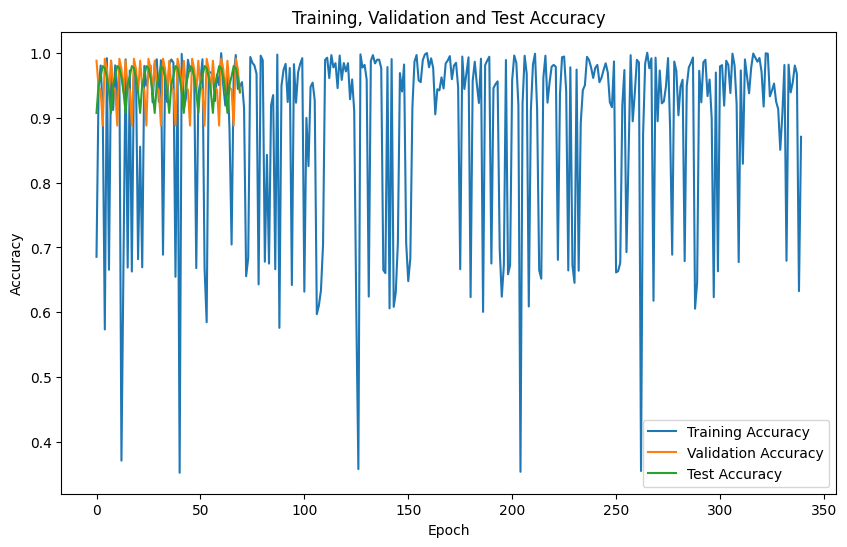

In [10]:
import matplotlib.pyplot as plt

# Calculate and plot training and validation accuracy
train_acc = []
val_acc = []
test_acc = []

model.eval()

with torch.no_grad():
    for i in range(10):  # Run for 10 epochs
        for images, masks, bbox_labels in train_loader:
            outputs = model(images)
            train_acc.append((outputs.sigmoid() > 0.5).eq(masks).float().mean().item())
        for images, masks, bbox_labels in val_loader:
            outputs = model(images)
            val_acc.append((outputs.sigmoid() > 0.5).eq(masks).float().mean().item())
        for images, masks, bbox_labels in test_loader:
            outputs = model(images)
            test_acc.append((outputs.sigmoid() > 0.5).eq(masks).float().mean().item())

plt.figure(figsize=(10, 6))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot(test_acc, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training, Validation and Test Accuracy')
plt.legend()
plt.show()